## Generate toy Dataset

In [123]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(-1, 1)

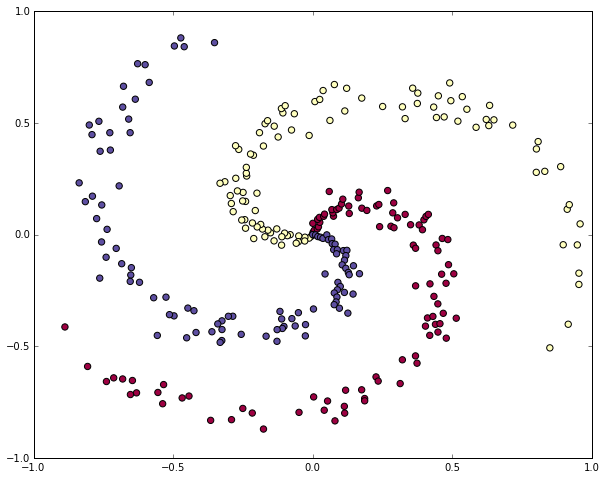

In [124]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

## Softmax

In [63]:
# random param init
reg = 0.01
num_examples = X.shape[0]
dim = X.shape[1]
num_classes = K
W = 0.01 * np.random.randn(D, K) # [Dimension, num_classes]
b = np.zeros((1,K)) # [1, num_classes]

# D = 2, K = 3

In [64]:
X.shape, W.shape, b.shape

((300, 2), (2, 3), (1, 3))

###Compute class scores

In [65]:
# no bias trick? =( 
scores = np.dot(X, W) + b # adds bias vector to each score row (broadcast)
scores.shape


(300, 3)

### Compute the loss to quantify our misery!

In [68]:
# get unnormed probabilities
exp_scores = np.exp(scores)
# normalize them per examples
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
# keepdims true to get [3,1] vector instead of 3,0 so broadcasting will work
# each row sums to 1

# get log probs assigned to the correct classes
correct_logprobs = -np.log(probs[np.arange(num_examples), y])

# average cross-entropy loss
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5 * reg * np.sum(W*W)
loss = data_loss + reg_loss


### Computing the Analytic Gradient

In [83]:
# gradient tells us what the influence on the loss each param has
# negative gradient means if we increase that thing the loss will decrease!

# start with the gradient of the loss function
dscores = probs
dscores[np.arange(num_examples),y] -= 1
dscores /= num_examples

# scores = np.dot(X, W) + b we have dscores so we can now get dW and db
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # add reg to weights


### Parameter update

In [77]:
# change weights in the opposite direction of grad
# remember negative gradient means if we increase that thing the loss will 
# decrease! so we want to increase things with a negative gradient!
step_size = 1
W += -step_size * dW
b += -step_size * db

### Putting it all together

In [87]:
# random init
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# hyper params
step_size = 1e-0
reg = 1e-3 # reg strength

# gradient descent loop 
num_examples = X.shape[0]
for i in xrange(200):
    
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b
    
    
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    
    
    # compute the loss: average cross-entropy loss plus regularization
    correct_logprobs = -np.log(probs[np.arange(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 00.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print "iteration %d: loss %f" % (i, loss)
        
    
    # compute the gradient on scores
    dscores = probs
    dscores[np.arange(num_examples),y] -= 1
    dscores /= num_examples
    
    # backprop the gradient to the parameters (W, b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True) # sum of each col prop through broadcasting
    
    dW += reg*W
    
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.097641
iteration 10: loss 0.917494
iteration 20: loss 0.851608
iteration 30: loss 0.822393
iteration 40: loss 0.807620
iteration 50: loss 0.799470
iteration 60: loss 0.794695
iteration 70: loss 0.791773
iteration 80: loss 0.789927
iteration 90: loss 0.788731
iteration 100: loss 0.787941
iteration 110: loss 0.787411
iteration 120: loss 0.787051
iteration 130: loss 0.786804
iteration 140: loss 0.786633
iteration 150: loss 0.786515
iteration 160: loss 0.786431
iteration 170: loss 0.786373
iteration 180: loss 0.786332
iteration 190: loss 0.786302


### Evaluate training set accuracy

In [93]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.49


### plot resulting classifier

(-1.8712034092398278, 1.8687965907601756)

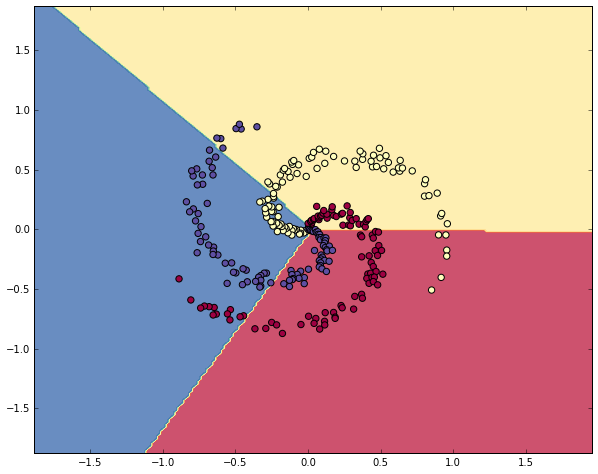

In [94]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

Dataset not linearly seperable so linear classifier can't fit it

### Neural Net

In [95]:
# init random params
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h)) # add bias offset to hidden layer (scores)
W2 = 0.01 * np.random.randn(h,K) # transforms hidden 100 d output to K dim output
b2 = np.zeros((1,K)) # add bias to scores

### Forward Pass

In [96]:
# evaluate class scores with a 2-layer NN (one hidden layer)
hidden_layer = np.maximum(0, np.dot(X, W) + b) # ReLU activation dW = X, db = 1
scores = np.dot(hidden_layer, W2) + b2 # dhidden = W2,note we treat hidden layer output as input to this layer

### Eval Loss (same as softmax)

In [109]:
# scores are viewed as unnormed log probabilities log * exp = 1 so lets get probs!
exp_scores = np.exp(scores)
# divide by row totals to norm!
probs = exp_scores /  np.sum(exp_scores, axis=1, keepdims=1)
# loss is just the -log of the score we gave to the correct class
# find correct class probs
correct_logprobs = -np.log(probs[np.arange(num_examples), y])
data_loss = np.sum(-np.log(correct_logprobs))/num_examples
# add regularization for both sets of weights
reg_W = 0.5*reg*np.sum(W*W)
reg_W2 = 0.5*reg*np.sum(W2*W2)
reg_loss = reg_W + reg_W2
loss = data_loss + reg_loss 

### Backprop

In [110]:
# calculate the effect of scores on the loss (dscores)
dscores = probs
dscores[np.arange(num_examples),y] -= 1 # make sure correct scores have neg gradient
dscores /= num_examples 

# backprop to the parameters
# first into W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

# dW2 and dWb are the ends of our comp graph but hidden_layer is a function of 
# other paramers and data, lets backprop through!
# our gradient from the top is still dscores, the local gradient is W2!
dhidden = np.dot(dscores, W2.T) # should be same dim as hidden layer
# backprop through ReLU local grad will be 1 if x > 0 and 0 if less than 0
# since we are carrying the grad form the top (dhidden) this means we just kill
# dhidden anywhere hidden was zero
dhidden[hidden_layer <= 0] = 0
# into W,b
dW = np.dot(X.T, dhidden) # local dW = X * grad from the top dhidden
db = np.sum(dhidden, axis=0, keepdims=True) # local db = 1 * grad from top (sum over cols for broadcasting)

### Full NN

In [116]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):
    
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0,np.dot(X, W) + b) # N x H # local grads: (relu kill if below 0), dW = X, db =1
    scores = np.dot(hidden_layer, W2) + b2 # N x K local grads: dhidden = W2, dW2 = hidden, b2 = 1
    
    #compute class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # compute average cross-entropy loss
    correct_logprobs = -np.log(probs[np.arange(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)
        
    # compute gradient on the loss
    dscores = probs
    dscores[np.arange(num_examples),y] -= 1 # subtract one for correct probs
    dscores /= num_examples
    # backprop into dW2 and db2
    dW2 = np.dot(hidden_layer.T, dscores) # H x N * N x k = [H x k] same as W2
    db2 = np.sum(dscores, axis=0, keepdims=True) # dscores is [N x K] b2 = [1 x K], undo broadcasting
    # backprop into hidden layer! it is a function with params we can change
    dhidden = np.dot(dscores, W2.T) # local grad is W2, dscores is carried from the top using chain rule
    # now go through relu (kill grads if hidden <= 0)
    dhidden[hidden_layer <= 0] = 0
    # on to W and b, still carrying dhidden with the chain rule
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
    
    # add gradient from regularization
    dW2 += reg * W2
    dW += reg * W
    
    # perform a parameter update
    W += - step_size * dW
    b += - step_size * db
    W2 += - step_size * dW2
    b2 += - step_size * db2

iteration 0: loss 1.098744
iteration 1000: loss 0.281070
iteration 2000: loss 0.253490
iteration 3000: loss 0.247802
iteration 4000: loss 0.246319
iteration 5000: loss 0.246084
iteration 6000: loss 0.245884
iteration 7000: loss 0.245665
iteration 8000: loss 0.245331
iteration 9000: loss 0.245073


### Training Accuracy

In [120]:
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1) # get highest score in each row
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.98


(-1.8712034092398278, 1.8687965907601756)

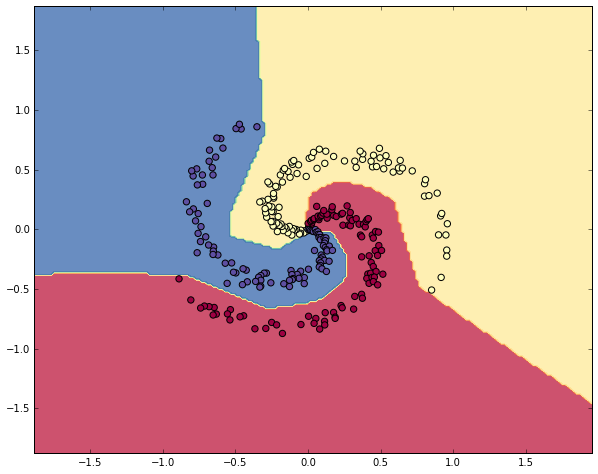

In [122]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')